# t-SNE visualization of Amazon Food Reviews Assignment


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - unqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review

#### Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

To determine this we could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms

   1. .csv file
   2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [54]:
# using the SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID 
""", con)  # sort by product ID
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


We can that in above example, the same user has multiple reviews with the same values for UserId, Profile Name, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text. 

And on doing analysis it was found that
1. ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

2. ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

After analysis it was inferred that, reviews with same parameters other than ProductId, belonged to the same product with just different flavour or quantity. Hence in order to reduce redundancy it's better to eliminate the rows having same parameters.

The method used to perfor deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace=False, kind='quicksort', na_position='last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicates :', final_data.shape)


Total number of reviews in the dataframe after removing duplicates : (364173, 10)


In [5]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]

final_data.shape

(364171, 10)

In [6]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [7]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Observation:-
1. From the above output we can see that there are many positive reviews and fewer negative reviews.

## Text Preprocessing: Stemming, stop-word removal and Lemmatization

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the words  to lowercase
6. Remove Stopwords
7. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [8]:
# find sentences containing HTML tags
import re
i=0;
for sentence in final_data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print(i)
        print(sentence)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [9]:
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
# nltk - Natural Language Processing Toolkit
# re - regular expression
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#prints all the set of stopwords in english
stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer, created a variable sno

# function to clean the word of any html-tags and replaces the sentence in angular braces <-----> with one space ' '
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence) # sub-substitute
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence) #replace with empty string
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('\n','length of stopwords set' , len(stop))
print('************************************')
# Stemming - Converting the words into their base word or stem word or root word
print(sno.stem('tasty'))

{'been', 'again', 'about', 'further', 'doing', 'are', 'be', "won't", 'should', 'and', 'those', 'so', 'your', 'herself', "you'd", 'above', 'itself', 'now', "aren't", 'what', "that'll", 'will', 's', 'll', 'but', 'then', 'shouldn', 'himself', 'while', 'by', 'more', 'out', 'themselves', 'of', 'too', 'after', 'am', 'isn', 'under', "shan't", 'aren', "wouldn't", "she's", 'is', "you've", 'wasn', 'it', "couldn't", "hadn't", "it's", 'theirs', 'don', 'here', 'ma', 'this', 'in', 'very', 'any', 'below', 'was', 'how', 'didn', 'ours', 'you', 'wouldn', 'mightn', 'each', 'have', 'they', 'its', 'before', 'than', 'until', 'she', 'the', 'for', 'hasn', 'i', 'yourselves', 'or', 'nor', 'won', "you're", "shouldn't", 'yourself', 'if', 'can', 'when', 'during', 'that', 'an', "you'll", "wasn't", 'just', 'as', "weren't", 'into', 'we', 'hers', 'our', 'were', 'm', 'ain', 'there', "hasn't", 'doesn', 'all', 'no', 'needn', 'same', 'who', 'a', 'some', 're', 'up', 'their', 'd', 'he', 'once', 'shan', 'from', 'ourselves', 

In [10]:
# step-by-step code to perform all pre-processing steps and to clean the text data

i=0
str1=' '
final_string=[]  # creating final string which is list of final strings after all the processing
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sentence in final_data['Text'].values:
    filtered_sentence=[]
    #print(sent); 
    sentence=cleanhtml(sentence) # remove HTMl tags
    for w in sentence.split():  # splitting the words
        for cleaned_words in cleanpunc(w).split():  # cleaning the punctuation for each word
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):  # checking if the words are alphanumeri and len is >2
                if(cleaned_words.lower() not in stop):  # converting words into lowercase and removing stopwords
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')  # performing stemming on the words
                    filtered_sentence.append(s)  # after all the above processing steps, final sentence is stored in this
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all  positive words 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all negative words
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) # joining the filtered sentence to construct the final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1



In [11]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [12]:
#adding a column of CleanedText and storing all the strings of every review obtained after pre-processing steps
final_data['CleanedText']=final_string 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
final_data.shape
final_data.head(3)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [13]:

print(final_data['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


## Bi-Grams and n-grams


Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [14]:
freq_dist_positive=nltk.FreqDist(all_positive_words) 
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

print('Total number of the positive words' ,len(all_positive_words))
print('Total number of the negative words' ,len(all_negative_words))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]
Total number of the positive words 11610503
Total number of the negative words 2354489


#### Observation:-  

From the above output it can be seen that the most common positive and the negative words overlap. for eg. 'like' could be used as 'not like' etc.
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

1. In case of uni-grams, one dimension is created for for every word in the dataset which means each word is considered a dimension. But instead of using one word at a time, we can use pairs of words called Bi-grams.

### Bi-Grams
1. BoW discards the sequence information, so by using Bi-Grams or n-grams we can retain sequence information partially.
2. Pairs of consecutive words are considered as a dimension.
3. The number of bi-grams in any text is greater than number of uni-grams
4. If there are n-grams (n>1) then dimensionality d increases

In [15]:
#bi-gram, tri-gram and n-gram
# ngram_range=(1,2) gives all the 1=uni-grams and 2=bi-grams. This is the range of n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))

# If we increase the n-gram range then dimensionality also increases
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


#### Observation:-
1. By using Bi-grams we got 2923725 dimensions data which has drastically increased from uni-grams 
2. So if we increase the 'n' value in n-grams then dimesions also increase.

## Bag of Words (BoW)

1. It is one of the simple technique to convert text to vector.
2. Constructs a dictionary with set of all the unique words in the reviews. 
3. Next construct a vector of size 'd' for d-unique words. Each index corresponds to one word in the dictionary.
4. Each word is different dimension in d-dim vector and each cell in vector corresponds to number of times the corresponding word occurs in review.
5. There are different BoW. One is Binary BoW - it says that, instead of specifying the count of number of occurances, it will specify whether the word occurs or not. This is also called boolean BoW.
6. BoW can be said as number of differing words

In [16]:
#BoW
# Taking equal sample of negative and positive reviews.
positive_pts = final_data[final_data['Score'] == 'positive'].sample(n=3000)
negative_pts = final_data[final_data['Score'] == 'negative'].sample(n=3000)

# Concatenating both positive and negative points
total_score = pd.concat([positive_pts, negative_pts])
total_score.shape


(6000, 11)

In [17]:
# Storing class label 'Score' in a variable called score_6000
score_6000 = total_score["Score"]
score_6000.shape

(6000,)

In [18]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
count_vect = CountVectorizer() #in scikit-learn

# total score data is converted to values and is stored in final_counts
final_counts = count_vect.fit_transform(total_score['CleanedText'].values)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ",type(final_counts)) # gets the type of final_counts which is a matrix

# gets the shape of the matrix
print("the shape of out text BOW vectorizer ",final_counts.get_shape()) 

print("the number of unique words are ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 10730)
the number of unique words are  10730


## t-SNE for BoW

In [19]:
#Scaling
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scalar = StandardScaler(with_mean=False)
standard_data = scalar.fit_transform(final_counts)
print("Final shape of matrix", standard_data.shape)


Final shape of matrix (6000, 10730)


In [20]:
type(standard_data)

scipy.sparse.csr.csr_matrix

In [21]:
standard_data = standard_data.todense()

In [22]:
type(standard_data)

numpy.matrixlib.defmatrix.matrix

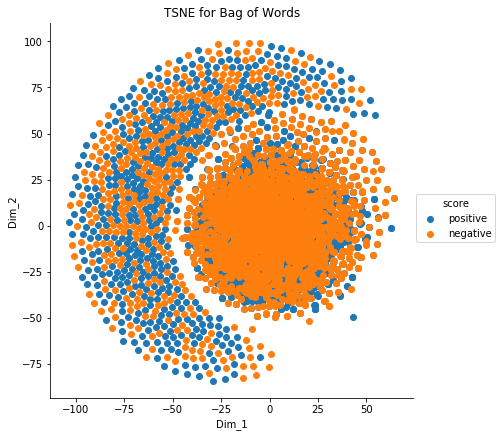

In [23]:
# TSNE Plot
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 1000)

tsne_bow_data = model.fit_transform(standard_data)

# creating a new data frame which help us in ploting the result data
tsne_bow_data = np.vstack((tsne_bow_data.T, score_6000)).T
tsne_df = pd.DataFrame(data=tsne_bow_data, columns=("Dim_1", "Dim_2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()


##### Observation:- 
In this TSNE plot for BoW we cannot seperate positve reviews and negative reviews. Both are overlapping with each other.

## TF-IDF

1. TF-IDF is Term Frequency-Inverse Document Frequency
2. TF of any word in any review is = number of times the word occurs in a review (or) document / Total number of words in review.
3. TF of any word in any review, lies between 0 and 1 , which we can interpret as probability. TF is the probability of finding a word in a document or review Rj.
4. The more often the word occurs, the higher the TF will be.
5. Techniques like BoW, TF-IDF are done for information retrieval (part of NLP)
6. IDF is always measured for a given word in entire Dataset(Dc) or corpus, where D is the set of all reviews/documents.
7. IDF of any given word in Dataset is = log(Number of documents(N)in a Dataset /(ni)number of documents which contains word) where ni <= N and  log(N/ni)>=0 this is IDF.
8. So IDF of any word in any document corpus is >=0. If ni increases then IDF will be lower and viceversa.
9. If Wi(word) is more frequent in documents then its IDF will be low, if Wi is a rare word then IDF will be higher.
10. So for the given reviews in a Dataset D, TF-IDF = TF(Wi,Rj)* IDF(Wi,Dc).
11. In TF-IDF more importance is given to the words which are rarer in Dataset Dc and to the words which are frequent in a review/document.
12. The drawback of TF-IDF is, it doesn't take semantic meaning of the word into consideration.


In [24]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
final_tf_idf = tf_idf_vect.fit_transform(total_score['CleanedText'].values)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 164198)
the number of unique words including both unigrams and bigrams  164198


In [25]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)


164198

In [26]:
print("some sample features(unique words in the corpus) are:")
features[3000:3010]

some sample features(unique words in the corpus) are:


['almost gone',
 'almost gonna',
 'almost good',
 'almost got',
 'almost graini',
 'almost half',
 'almost herbal',
 'almost hidden',
 'almost hit',
 'almost ident']

In [27]:
# W can see all the column values for a particular column (say 5) and we get a numpy array where most of the values are 0 and very few values are 1

print(final_tf_idf[5,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [28]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,20)


In [29]:
top_tfidf

,feature,tfidf
0,best kind,0.214172
1,nice breakfast,0.214172
2,kind great,0.214172
3,nut plus,0.214172
4,perfect love,0.214172
5,compani feel,0.214172
6,plus kind,0.214172
7,love nut,0.204530
8,snack flavor,0.204530
9,kind,0.203724


#### Observation:- 
In this output we get top 20 terms/words in a given review/sentence. These words can be unigrams or bi-grams 

## t-SNE for TF-IDF

In [30]:
#Scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scalar = StandardScaler(with_mean=False)
standard_data = scalar.fit_transform(final_tf_idf)
print("Final shape of matrix", standard_data.shape)


Final shape of matrix (6000, 164198)


In [31]:
type(standard_data)

scipy.sparse.csr.csr_matrix

In [32]:
standard_data = standard_data.todense()

In [33]:
type(standard_data)

numpy.matrixlib.defmatrix.matrix

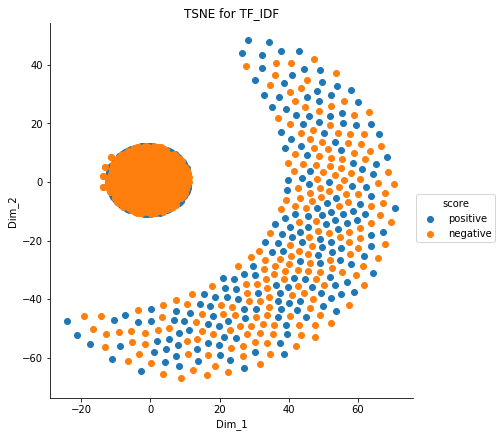

In [34]:
# TSNE Plot for TF-IDF
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 1000)

tsne_tf_idf_data = model.fit_transform(standard_data)

# creating a new data frame which help us in ploting the result data
tsne_tf_idf_data = np.vstack((tsne_tf_idf_data.T, score_6000)).T
tsne_df = pd.DataFrame(data=tsne_tf_idf_data, columns=("Dim_1", "Dim_2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF_IDF")
plt.show()


#### Observation:-
In this TSNE plot also we cannot seperate positive and negative reviews. So lets see in other TSNE representations.

## Word2Vec

In [35]:
# I am Training Word2Vec model using Amazon fine food text corpus
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent=[]
for sent in total_score['CleanedText'].values:
    list_of_sent.append(sent.split())
    

In [37]:
# One sentence is converted into a list
print(total_score['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

mayb would someon say stop eat seem unabl stop eat great flavor textur hard soggi realli rich depth flavor lolli general fixat organ demonstr proper attent ingredi realli make impact flavor qualiti finish product high recommend
*****************************************************************
['mayb', 'would', 'someon', 'say', 'stop', 'eat', 'seem', 'unabl', 'stop', 'eat', 'great', 'flavor', 'textur', 'hard', 'soggi', 'realli', 'rich', 'depth', 'flavor', 'lolli', 'general', 'fixat', 'organ', 'demonstr', 'proper', 'attent', 'ingredi', 'realli', 'make', 'impact', 'flavor', 'qualiti', 'finish', 'product', 'high', 'recommend']


In [38]:
# Train the word2vec model
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)


In [39]:
# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words = list(w2v_model.wv.vocab)
print(len(words))

# prints 50 words
print("sample words ", words[0:50])

3698
sample words  ['mayb', 'would', 'someon', 'say', 'stop', 'eat', 'seem', 'unabl', 'great', 'flavor', 'textur', 'hard', 'soggi', 'realli', 'rich', 'depth', 'general', 'organ', 'proper', 'attent', 'ingredi', 'make', 'impact', 'qualiti', 'finish', 'product', 'high', 'recommend', 'best', 'kind', 'bar', 'ever', 'tast', 'calori', 'nice', 'breakfast', 'snack', 'perfect', 'love', 'nut', 'plus', 'compani', 'feel', 'good', 'buy', 'cat', 'age', 'year', 'thrive', 'food']


In [40]:
w2v_model.wv.most_similar('tasti')

[('salti', 0.9971376657485962),
 ('without', 0.9952304363250732),
 ('creami', 0.9949101209640503),
 ('cinnamon', 0.9946568012237549),
 ('bland', 0.9946290254592896),
 ('caramel', 0.9931671023368835),
 ('spici', 0.9930410385131836),
 ('banana', 0.992775559425354),
 ('nutti', 0.992694616317749),
 ('crunchi', 0.992237389087677)]

In [42]:
w2v_model.wv.most_similar('like')

[('tast', 0.9584398865699768),
 ('realli', 0.9561982154846191),
 ('smell', 0.9522430896759033),
 ('doesnt', 0.9475278258323669),
 ('textur', 0.9417563676834106),
 ('strong', 0.9336597323417664),
 ('enjoy', 0.9203330278396606),
 ('flavor', 0.9199255704879761),
 ('bitter', 0.9155583381652832),
 ('aftertast', 0.9098008871078491)]

In [43]:
# list of words in BoW
count_vect_feat = count_vect.get_feature_names()
print(len(count_vect_feat))

10730


In [44]:
# Prints index of word like
count_vect_feat.index('like')


5371

In [46]:
# Prints word at the index 5357
print(count_vect_feat[5371])

like


## Avg-Word2Vec

1. We take the average of all word2vec(vector) representations of all words in a review and divide them by number of words in a review. This is vector representation of a review. 


In [47]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

6000
50


## t-SNE for Avg Word2Vec

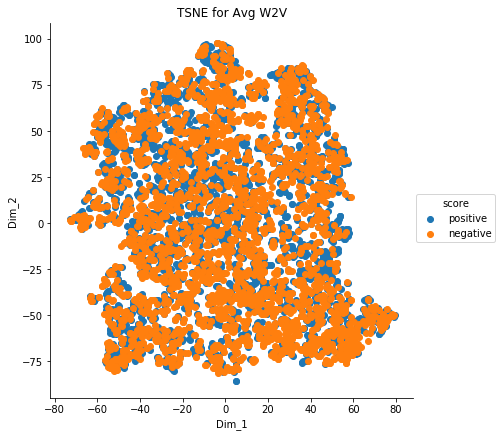

In [48]:
# TSNE Plot
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 1000)

tsne_avgw2v_data = model.fit_transform(sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_avgw2v_data = np.vstack((tsne_avgw2v_data.T, score_6000)).T
tsne_df = pd.DataFrame(data=tsne_avgw2v_data, columns=("Dim_1", "Dim_2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Avg W2V")
plt.show()


#### Observation:-
In the TSNE for Avg W2V, we cannot seperate the positive and negative reviews. There is lot of overlapping with eachother.

## TFIDF-W2V

In [49]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(total_score['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [50]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [00:07<00:00, 832.96it/s]


## t-SNE for TFIDF-W2V

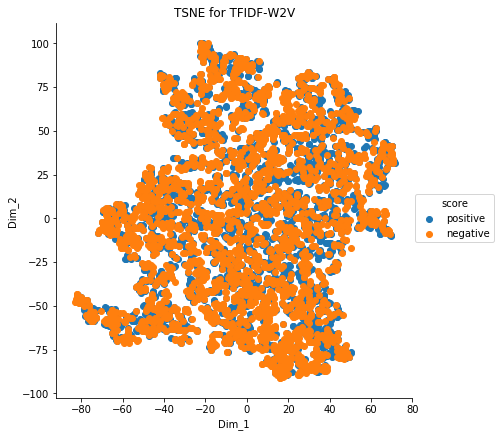

In [51]:
# TSNE Plot
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 1000)

tsne_tfidf_w2v_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_tfidf_w2v_data = np.vstack((tsne_tfidf_w2v_data.T, score_6000)).T
tsne_df = pd.DataFrame(data=tsne_tfidf_w2v_data, columns=("Dim_1", "Dim_2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TFIDF-W2V")
plt.show()


#### Observation:-
1. This plot also looks same as above 3 TSNE plots. Here also positive and nagative reviews are not seperated.
2. So none of the TSNE representations gives well seperated positve and negative reviews.
3. We cannot seperate the reviews through hyperplane and all the reviews are overlapping with each other, so even though TSNE is a great technique to visualize high dimensional data, but still it is not able to seperate positive and negative reviews in Amazon fine food reviews dataset.